In [1]:
list.of.packages <- c("tidyverse","dplyr","sf","ggrepel","scales")

new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos = "http://cran.us.r-project.org")

invisible(lapply(list.of.packages, library, character.only = TRUE))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.3
✔ tibble  3.1.0     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Linking to GEOS 3.5.1, GDAL 2.2.2, PROJ 4.9.2


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




### Read country shapefile

In [2]:
countries <- st_read('../0_Reference_files/country_shapefile/ne_10m_admin_0_countries.shp')

Reading layer `ne_10m_admin_0_countries' from data source `/home/cired/Documents/CIRED/Revise_Paper_Franck/Clean_Database_14_11_2020/0_Reference_files/country_shapefile/ne_10m_admin_0_countries.shp' using driver `ESRI Shapefile'
Simple feature collection with 255 features and 94 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -180 ymin: -90 xmax: 180 ymax: 83.6341
CRS:            4326


In [3]:
countries <- countries %>% 
                 mutate(
                    CENTROID = map(geometry, st_centroid),
                    COORDS = map(CENTROID, st_coordinates),
                    COORDS_X = map_dbl(COORDS, 1),
                    COORDS_Y = map_dbl(COORDS, 2)
                  )

### Database with one row for each publication-country association

In [4]:
path <- "../5_Final_databases/output/database_multi_rows_each_paper_one_per_country.csv"
df <- read_csv(path)
sprintf("%i x %i dataframe", nrow(df), ncol(df))

Parsed with column specification:
cols(
  .default = col_double(),
  Country = col_character(),
  title = col_character(),
  ISO_3 = col_character(),
  Region = col_character(),
  authors = col_character(),
  source = col_character(),
  doi = col_character(),
  abstract = col_character(),
  author_keywords = col_character(),
  model = col_character(),
  scopus_number = col_character(),
  WOS_number = col_character()
)

See spec(...) for full column specifications.



[1] "4884 x 53 dataframe"

### Count publications associated to each ISO3 and the relative proportion of the database

In [5]:
df <- df %>%
        group_by(ISO_3) %>%
        summarise(nb_pub = n()) %>%
        ungroup() %>%
        mutate(ratio = round(nb_pub/4691*100, digits = 1))
sprintf("%i x %i dataframe", nrow(df), ncol(df))
head(df)

[1] "137 x 3 dataframe"

ISO_3,nb_pub,ratio
<chr>,<int>,<dbl>
AFG,1,0.0
AGO,1,0.0
ALB,3,0.1
ARE,1,0.0
ARG,4,0.1
ATA,2,0.0


### Join count data and the shapefile based on ISO_3

In [6]:
df_map <-left_join(countries,df,by = c("ADM0_A3"="ISO_3"))
sprintf("%i x %i dataframe", nrow(df_map), ncol(df_map))

Warning message:
“Column `ADM0_A3`/`ISO_3` joining factor and character vector, coercing into character vector”


[1] "255 x 101 dataframe"

### Mapping

#### Define breaks to color the legend

In [7]:
pretty_breaks <- c(10,20,50,100,200,300,400,500,1000) 
minVal <- min(df_map$nb_pub, na.rm = T)
maxVal <- max(df_map$nb_pub, na.rm = T)
brks <- c(minVal, pretty_breaks, maxVal)

In [8]:
options(scipen=10000)

df_map$brks <- cut(df_map$nb_pub, breaks = brks,include.lowest = TRUE,dig.lab=10)
brks_scale <- levels(df_map$brks)
labels_scale <- rev(brks_scale)

#### Create a Theme

In [9]:
theme_map <- function(...) {
  # On part du theme minimal, qui existe déjà
  theme_minimal() +
    # on retire juste les axes
    theme(
      axis.line = element_blank(),
      axis.text.x = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks = element_blank(),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.background = element_rect(fill = "aliceblue")
    )
}

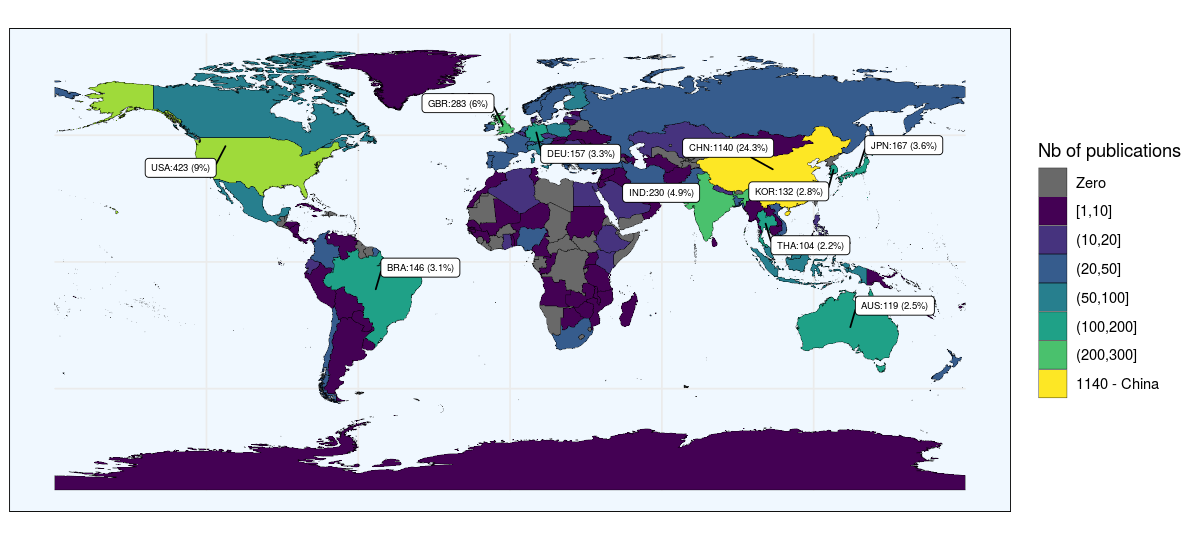

In [10]:
options(repr.plot.width=10, repr.plot.height=4.5)

map <- ggplot(data = df_map) + 
      geom_sf(aes(fill = brks), size = 0.1, color = 'black') + 
      scale_fill_viridis_d(name = "Nb of publications", na.value = "dimgray",
                           breaks=c(NA,"[1,10]","(10,20]","(20,50]","(50,100]",
                                     "(100,200]","(200,300]","(300,400]","(1000,1140]"),
                           label = c("Zero","[1,10]","(10,20]","(20,50]","(50,100]",
                                     "(100,200]","(200,300]","(300,400]","1140 - China")
                           ) + 
      geom_label_repel(inherit.aes = FALSE, data = subset(df_map, nb_pub>100), 
                       aes(x = COORDS_X, y = COORDS_Y, label = paste0(ADM0_A3,":",nb_pub, " (", ratio, "%)")), 
                       size = 2, box.padding = unit(0.5, "lines")) +
      theme_map()
map

In [11]:
ggsave('./output/Fig1_map_literature.png', height=4.5, width=10, plot=map)